In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
!pip install Augmentor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin_cancer/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin_cancer/Test")


image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Images in the train folder:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Images in the test folder:', image_count_test)

Mounted at /content/drive
Images in the train folder: 2239
Images in the test folder: 118




### Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print('\n')
print(class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


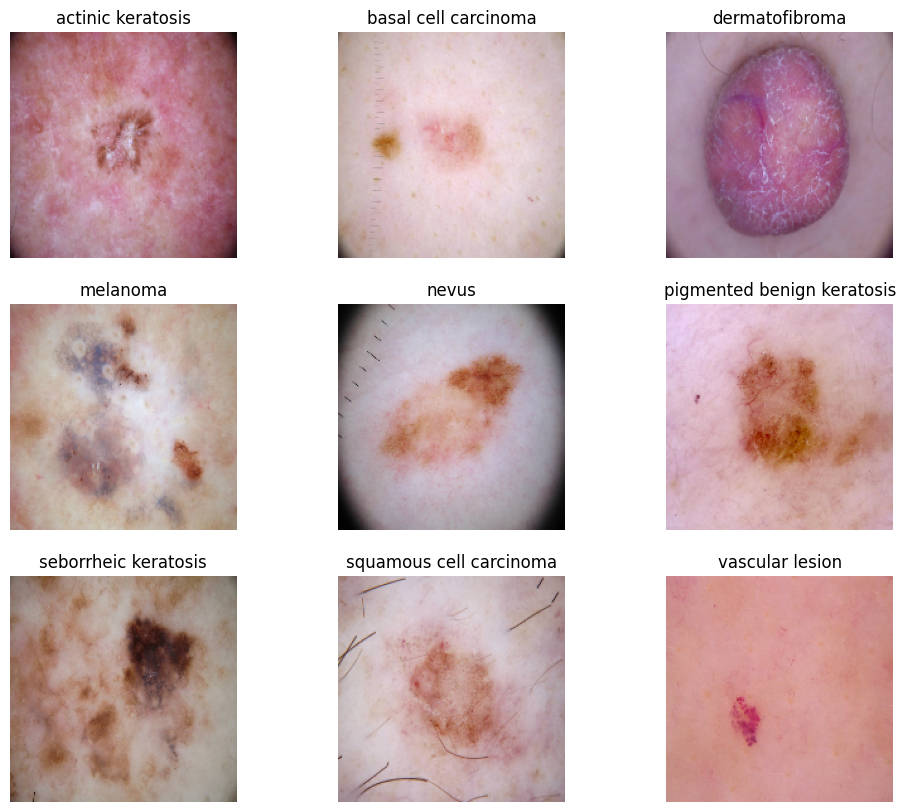

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Define a function to filter and take images for each class
def take_images_for_class(class_label):
    class_label = tf.cast(class_label, tf.int32)  # Convert to int32
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], class_label))
    return filtered_ds.take(1)

# Use interleave to load images concurrently
interleaved_ds = tf.data.Dataset.range(len(class_names)).interleave(
    lambda x: take_images_for_class(x),
    cycle_length=len(class_names),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Visualize the images
for i, (image, label) in enumerate(interleaved_ds):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

plt.show()


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Flatten

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),  # Adjusted dropout rate

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adjusted dropout rate

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [9]:
# Train the model
epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 85s 961ms/step - loss: 2.0752 - accuracy: 0.2606 - val_loss: 1.7442 - val_accuracy: 0.4094
Epoch 2/30
56/56 [==============================] - 3s 57ms/step - loss: 1.8066 - accuracy: 0.3348 - val_loss: 1.6507 - val_accuracy: 0.4586
Epoch 3/30
56/56 [==============================] - 3s 60ms/step - loss: 1.6609 - accuracy: 0.4107 - val_loss: 1.5735 - val_accuracy: 0.4743
Epoch 4/30
56/56 [==============================] - 3s 59ms/step - loss: 1.5296 - accuracy: 0.4699 - val_loss: 1.4822 - val_accuracy: 0.5257
Epoch 5/30
56/56 [==============================] - 3s 57ms/step - loss: 1.4465 - accuracy: 0.5078 - val_loss: 1.4104 - val_accuracy: 0.5481
Epoch 6/30
56/56 [==============================] - 3s 59ms/step - loss: 1.4063 - accuracy: 0.5145 - val_loss: 1.5809 - val_accuracy: 0.5034
Epoch 7/30
56/56 [==============================] - 3s 57ms/step - loss: 1.3884 - accuracy: 0.5156 - val_loss: 1.5514 - val_accuracy: 0.4810
Epoch 8/30
56/56 [====

### Visualizing training results

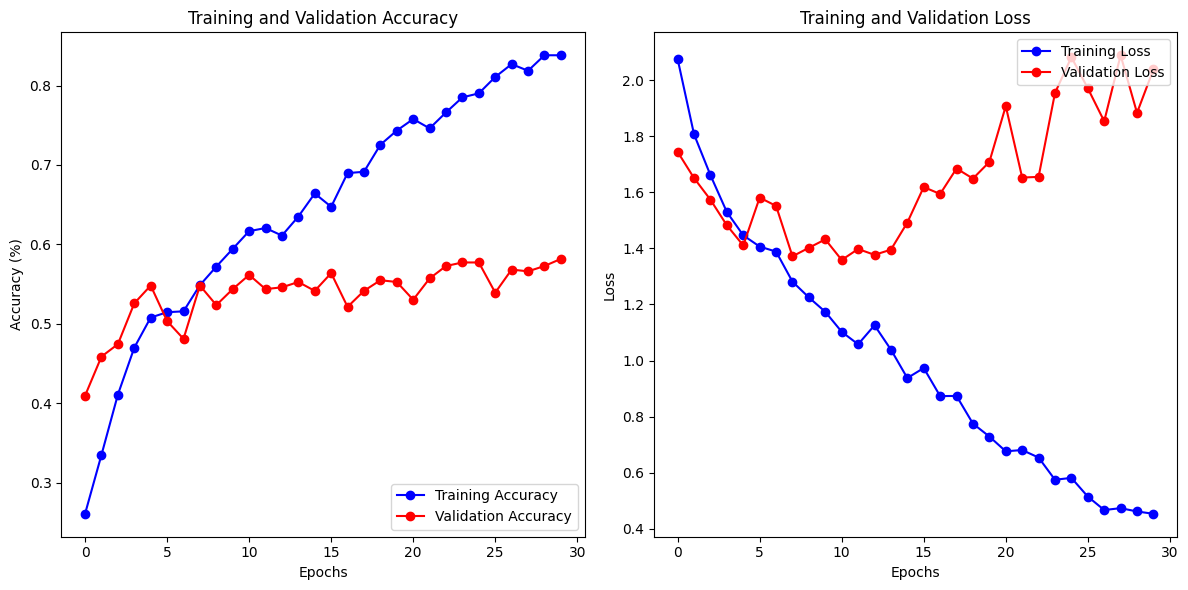

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### Data Augmentation

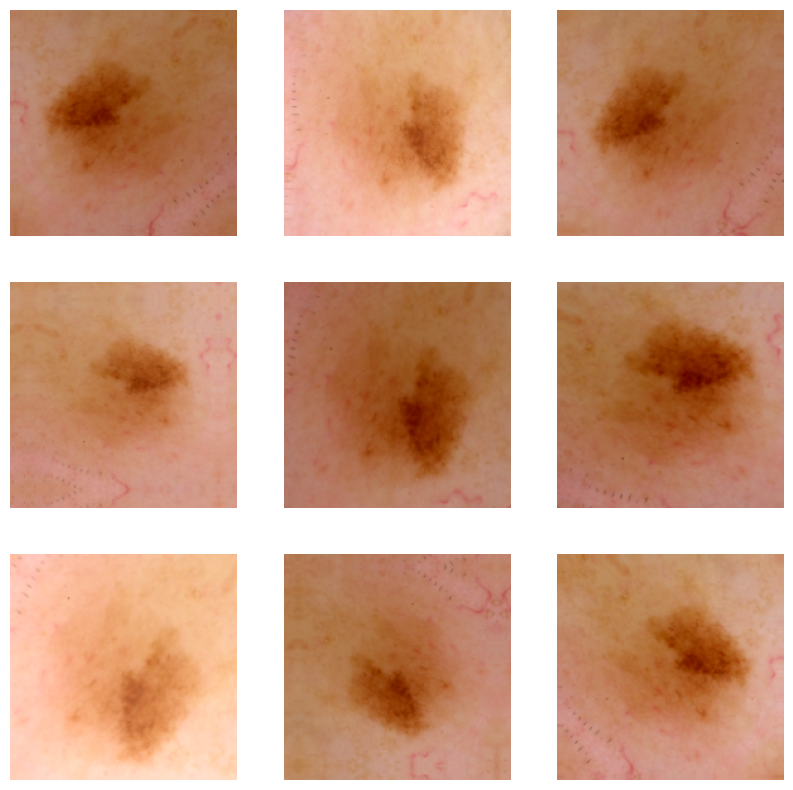

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.2),  # Increased rotation angle
        layers.RandomZoom(0.2),  # Increased zoom range
        layers.RandomContrast(0.2),  # Added random contrast
        layers.RandomBrightness(0.2),  # Added random brightness
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


### Create the model, compile and train the model


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Updated Learning Rate Schedule
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

# Model with updated learning rate, batch normalization, and adjusted dropout
model_with_augmentation = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),  # Adjusted dropout rate

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adjusted dropout rate

    layers.Dense(num_classes, activation='softmax')
])

model_with_augmentation.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Display the model summary
model_with_augmentation.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Training the model

In [13]:
# Train the model
epochs = 30
history_for_augmented = model_with_augmentation.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 7s 68ms/step - loss: 2.1161 - accuracy: 0.2478 - val_loss: 1.8931 - val_accuracy: 0.3490
Epoch 2/30
56/56 [==============================] - 4s 64ms/step - loss: 1.8307 - accuracy: 0.3404 - val_loss: 1.6414 - val_accuracy: 0.4474
Epoch 3/30
56/56 [==============================] - 4s 64ms/step - loss: 1.7077 - accuracy: 0.4012 - val_loss: 1.5398 - val_accuracy: 0.5101
Epoch 4/30
56/56 [==============================] - 4s 70ms/step - loss: 1.6051 - accuracy: 0.4414 - val_loss: 1.5487 - val_accuracy: 0.4318
Epoch 5/30
56/56 [==============================] - 4s 69ms/step - loss: 1.5645 - accuracy: 0.4503 - val_loss: 1.4541 - val_accuracy: 0.4966
Epoch 6/30
56/56 [==============================] - 4s 66ms/step - loss: 1.5318 - accuracy: 0.4526 - val_loss: 1.5092 - val_accuracy: 0.4676
Epoch 7/30
56/56 [==============================] - 4s 69ms/step - loss: 1.5665 - accuracy: 0.4576 - val_loss: 1.4634 - val_accuracy: 0.4676
Epoch 8/30
56

### Visualizing the results

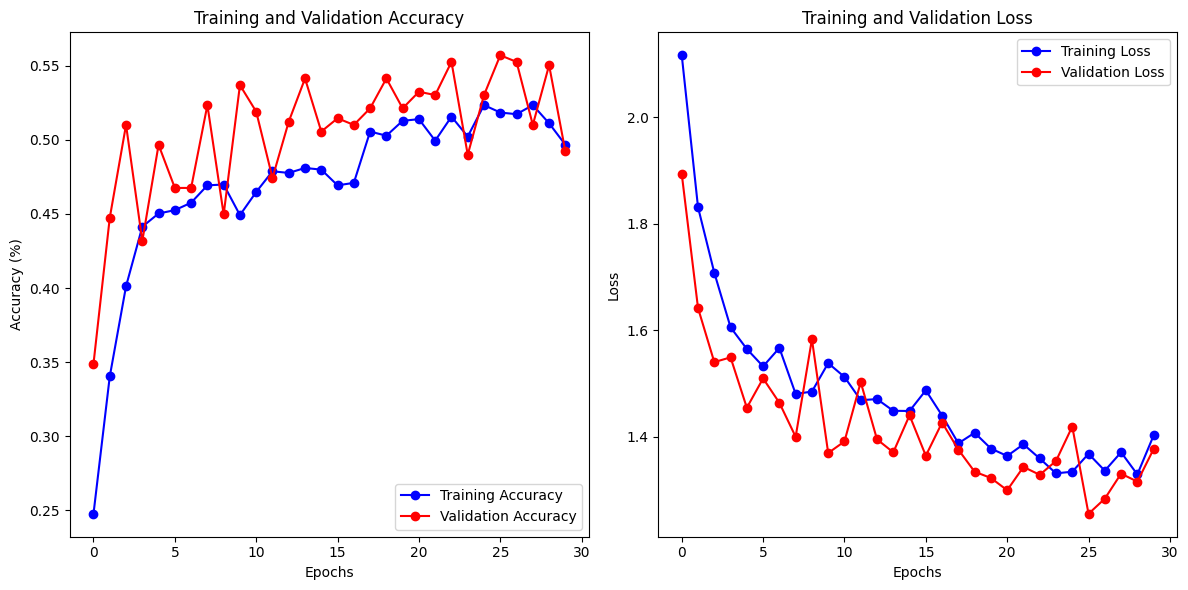

In [14]:
acc = history_for_augmented.history['accuracy']
val_acc = history_for_augmented.history['val_accuracy']

loss = history_for_augmented.history['loss']
val_loss = history_for_augmented.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [15]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/drive/MyDrive/Skin_cancer/Train/actin...,actinic keratosis
1,/content/drive/MyDrive/Skin_cancer/Train/actin...,actinic keratosis
2,/content/drive/MyDrive/Skin_cancer/Train/actin...,actinic keratosis
3,/content/drive/MyDrive/Skin_cancer/Train/actin...,actinic keratosis
4,/content/drive/MyDrive/Skin_cancer/Train/actin...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin_cancer/Train/vascu...,vascular lesion
2235,/content/drive/MyDrive/Skin_cancer/Train/vascu...,vascular lesion
2236,/content/drive/MyDrive/Skin_cancer/Train/vascu...,vascular lesion
2237,/content/drive/MyDrive/Skin_cancer/Train/vascu...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


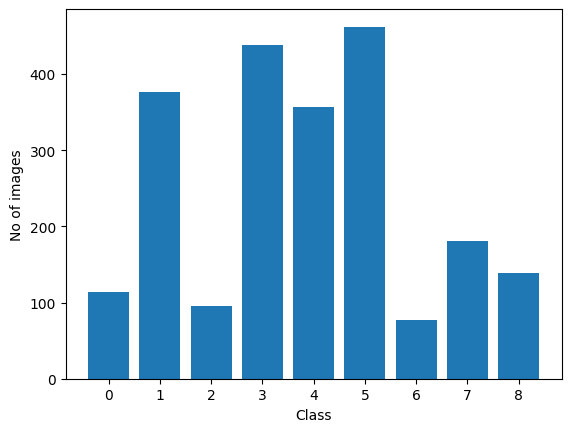

In [16]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

In [17]:
!pip install Augmentor

In [18]:
import Augmentor
from pathlib import Path

# Specify the path to the training dataset
path_to_training_dataset = '/content/drive/MyDrive/Skin_cancer/Train'

# Specify the output directory
output_dir = Path('/content/drive/MyDrive/Colab_Notebooks/output/')

# Create Augmentor pipeline for each class
for class_name in class_names:
    class_path = Path(path_to_training_dataset) / class_name
    output_class_dir = output_dir / class_name / 'output'

    # Create the output directory if it doesn't exist
    output_class_dir.mkdir(parents=True, exist_ok=True)

    # Augmentor pipeline
    p = Augmentor.Pipeline(str(class_path), output_directory=str(output_class_dir))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC20751B10>: 100%|██████████| 500/500 [00:39<00:00, 12.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CBA8158130>: 100%|██████████| 500/500 [00:27<00:00, 18.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CBA8177970>: 100%|██████████| 500/500 [00:27<00:00, 18.39 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CBA8158340>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CBA8143A00>: 100%|██████████| 500/500 [01:41<00:00,  4.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79CBA81CEB60>: 100%|██████████| 500/500 [00:25<00:00, 19.34 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CBA8158160>: 100%|██████████| 500/500 [00:52<00:00,  9.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CC42B9DDB0>: 100%|██████████| 500/500 [00:26<00:00, 19.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/output/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CBA8122FE0>: 100%|██████████| 500/500 [00:27<00:00, 18.00 Samples/s]


In [19]:
# Count the total number of augmented images
image_count_train = sum(len(list((output_dir / class_name / 'output').glob('*.jpg'))) for class_name in class_names)
print("\nTotal number of augmented images:", image_count_train)


Total number of augmented images: 18000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [20]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list[:5]

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

new_df['Label'].value_counts()

pigmented benign keratosis    2462
melanoma                      2438
basal cell carcinoma          2376
nevus                         2357
squamous cell carcinoma       2181
vascular lesion               2139
actinic keratosis             2114
dermatofibroma                2095
seborrheic keratosis          2077
Name: Label, dtype: int64

In [21]:
batch_size = 64
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
num_channels = 3

num_classes = len(class_names)

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing

# Assuming img_height, img_width, and num_channels are defined
normalization_layer = preprocessing.Normalization(input_shape=(img_height, img_width, 3))
normalization_layer.adapt(train_ds.map(lambda x, _: x))

In [31]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
base_model.trainable = True  # You can experiment with fine-tuning

model_additional_data = models.Sequential([
    data_augmentation,
    normalization_layer,
    base_model,

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

# Use a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

model_additional_data.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,  # Adjust patience based on your preference
    restore_best_weights=True,
    monitor='val_loss'
)

# Display the model summary
model_additional_data.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 normalization (Normalizati  (None, 180, 180, 3)       7         
 on)                                                             
                                                                 
 densenet201 (Functional)    (None, 5, 5, 1920)        18321984  
                                                                 
 global_average_pooling2d_1  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               983552    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

In [26]:
batch_size = 16

epochs = 30
history_added_data = model_additional_data.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
28/28 [==============================] - 44s 1s/step - loss: 1.9440 - accuracy: 0.3404 - val_loss: 1.9233 - val_accuracy: 0.4161
Epoch 2/30
28/28 [==============================] - 32s 1s/step - loss: 1.2912 - accuracy: 0.5893 - val_loss: 1.8423 - val_accuracy: 0.4609
Epoch 3/30
28/28 [==============================] - 32s 1s/step - loss: 1.0152 - accuracy: 0.6484 - val_loss: 1.5479 - val_accuracy: 0.5436
Epoch 4/30
28/28 [==============================] - 31s 996ms/step - loss: 0.8845 - accuracy: 0.6858 - val_loss: 1.2673 - val_accuracy: 0.5705
Epoch 5/30
28/28 [==============================] - 32s 972ms/step - loss: 0.7150 - accuracy: 0.7528 - val_loss: 1.1917 - val_accuracy: 0.5861
Epoch 6/30
28/28 [==============================] - 31s 914ms/step - loss: 0.6494 - accuracy: 0.7723 - val_loss: 1.0881 - val_accuracy: 0.6331
Epoch 7/30
28/28 [==============================] - 30s 947ms/step - loss: 0.5520 - accuracy: 0.7902 - val_loss: 0.9983 - val_accuracy: 0.6644
Epoch 8/

In [83]:
from google.colab import files

# Збереження ваг 1 моделі
model.save_weights('model_1.h5')
# Завантаження файлу з Google Colab
files.download('model_1.h5')

# Збереження ваг 2 моделі
model_with_augmentation.save_weights('model_2.h5')
files.download('model_2.h5')

# Збереження ваг 3 моделі
model_additional_data.save_weights('model_3.h5')
files.download('model_3.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
pip install PrettyTable


In [89]:
from sklearn.metrics import confusion_matrix
import numpy as np
from prettytable import PrettyTable

def calculate_performance_measures(y_true, y_pred):
    # Convert probabilities to class labels
    predicted_labels = np.argmax(y_pred, axis=1)

    # Assume the class with the highest predicted probability is the positive class
    positive_class = np.argmax(np.mean(y_pred, axis=0))

    # Create binary labels for the positive class
    true_labels_binary = (y_true == positive_class).astype(int)
    predicted_labels_binary = (predicted_labels == positive_class).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels_binary, predicted_labels_binary)

    # Extract TP, FP, TN, FN
    tp = cm[1, 1]
    fp = cm[0, 1]
    tn = cm[0, 0]
    fn = cm[1, 0]

    # Check for zero denominators
    if (tp + fp + tn + fn) == 0:
        # Handle the case where there are no samples
        return {
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'Specificity': np.nan,
            'F1-Score': np.nan,
            'Classification Error Rate': np.nan
        }

    # Calculate performance measures
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    classification_error_rate = (fp + fn) / (tp + fp + tn + fn)

    # Return the results
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'Classification Error Rate': classification_error_rate,
        'Confusion Matrix': cm
    }

In [54]:
!pip install tqdm


In [58]:
print('Actual number of images in the train folder:', image_count_train)


Actual number of images in the train folder: 18000


In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix

# Set up data augmentation for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Replace these placeholders with the actual paths to your test data directories
test_dir_model1 = '/content/drive/MyDrive/Skin_cancer/Test'
test_dir_model2 = '/content/drive/MyDrive/Skin_cancer/Test'
test_dir_model3 = '/content/drive/MyDrive/Skin_cancer/Test'

# Assuming you have test data generators for each model
test_generator_model1 = test_datagen.flow_from_directory(
    test_dir_model1,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator_model2 = test_datagen.flow_from_directory(
    test_dir_model2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator_model3 = test_datagen.flow_from_directory(
    test_dir_model3,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Assuming you have three trained models (model1, model2, model3)
models_list = [model, model_with_augmentation, model_additional_data]

# Assuming you have three test generators
test_generators = [test_generator_model1, test_generator_model2, test_generator_model3]

# Set the desired number of images to test
desired_num_images = 100

# Calculate the number of batches needed to reach the desired number of images
desired_steps = int(np.ceil(desired_num_images / batch_size))

# Evaluate models
for idx, model in enumerate(models_list, start=1):
    print(f"Evaluating Model {idx}")

    # Get predictions on a batch of test data
    predictions = model.predict(test_generators[idx-1], steps=desired_steps)

    # Optional: Print some information about predictions
    print("Example Predictions:")
    print(predictions[:5])  # Print predictions for the first 5 samples

    # Get true labels from the generator
    true_labels = test_generators[idx-1].classes[:desired_steps * batch_size]

    # Evaluate the model on the test set with a limited number of batches
    results = calculate_performance_measures(true_labels, predictions)

    # Create a PrettyTable for displaying results
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]

    # Add performance measures to the table
    for measure, value in results.items():
        table.add_row([measure, value])

    # Print the PrettyTable
    print(table)

    print(f"Evaluation for Model {idx} complete.\n")


Found 118 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Evaluating Model 1
7/7 [==============================] - 6s 931ms/step
Example Predictions:
[[1.0959964e-11 2.1846790e-07 1.2436838e-10 1.7754501e-02 5.5754662e-01
  4.2469463e-01 2.8907884e-06 4.9207334e-13 1.1275819e-06]
 [1.2476287e-11 2.3394425e-07 1.3861193e-10 1.7304111e-02 5.6201673e-01
  4.2067465e-01 2.8990221e-06 5.7616688e-13 1.3314364e-06]
 [1.3645673e-11 2.4285760e-07 1.4949704e-10 1.7737031e-02 5.6814986e-01
  4.1410843e-01 3.0439371e-06 6.3945583e-13 1.4221832e-06]
 [1.1221084e-11 2.1668851e-07 1.2421278e-10 1.7543873e-02 5.7226485e-01
  4.1018701e-01 2.8259742e-06 5.1515042e-13 1.3190519e-06]
 [1.4414996e-11 2.6113568e-07 1.5976266e-10 1.6677584e-02 5.5474037e-01
  4.2857736e-01 2.9560381e-06 6.7632602e-13 1.4826561e-06]]
+---------------------------+----------------------+
|           Metric          |        Value         |
+---------------------

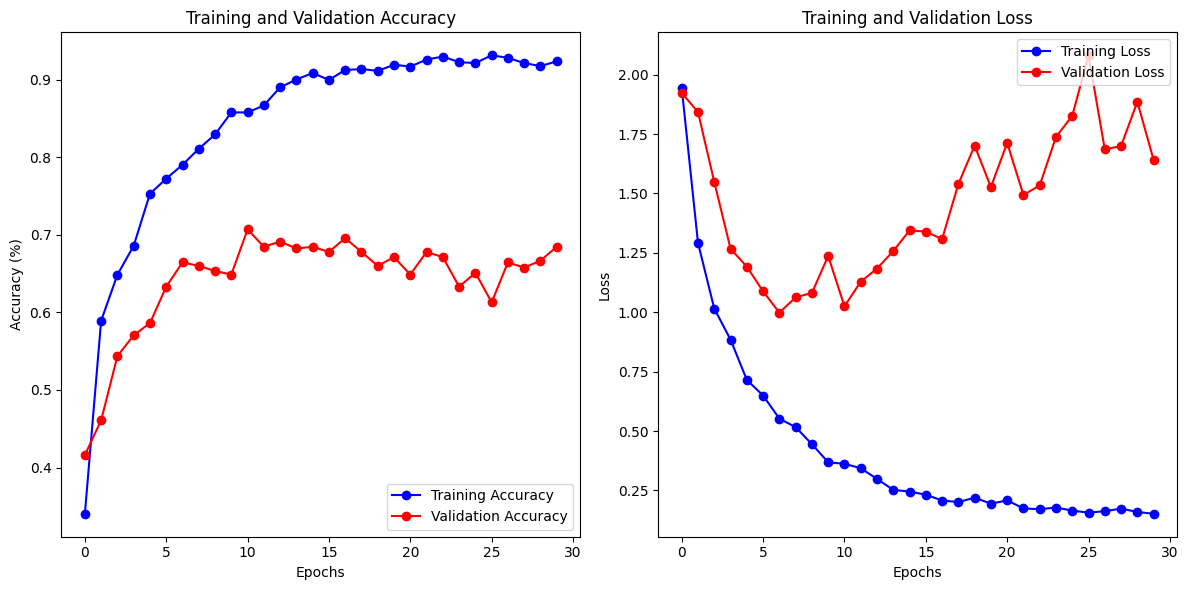

In [30]:
acc = history_added_data.history['accuracy']
val_acc = history_added_data.history['val_accuracy']

loss = history_added_data.history['loss']
val_loss = history_added_data.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()